# Линейная регрессия на синтетических данных (продолжение)

Рассматриваются следующие вопросы:
- Порождение новых признаков
- Гиперпараметры модели
- Проблема переобучения модели
- Кросс-валидация, тестовая и тренировочные выборки
- Масштабирование данных (стандартизация) 

### Полезные ссылки:
- <a href="https://numpy.org/">Numpy documentation</a><br />
- <a href="https://pandas.pydata.org/">Pandas documentation</a><br />
- <a href="https://matplotlib.org/">Matplotlib documentation</a><br />
- <a href="https://scikit-learn.org/stable/">sklearn documentation</a><br />

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Генерация данных 

Порождаем синтетические данные с зависимость y от x в форме многочлена 3-й степени. Для этого используем модель препроцессинга [PolynomialFeatures](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) библиотеки sklearn. 

X shape:  (20,)
X_poly shape:  (20, 4)


,0
0,-5.670086
1,0.665947
2,-0.743262
3,-5.076585
4,-5.564230


,0,1,2,3
0,1.0,-5.670086,32.149876,-182.292566
1,1.0,0.665947,0.443485,0.295337
2,1.0,-0.743262,0.552438,-0.410606
3,1.0,-5.076585,25.771713,-130.832284
4,1.0,-5.564230,30.960659,-172.272235


(-10.0, 10.0)

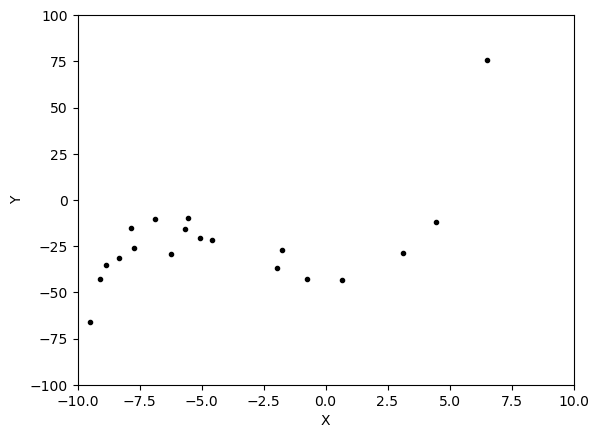

In [2]:
def generate_data (sample_size = 40):
    
    #true_degee = 4; true_theta = [0, -2.5, -1.9, -0.019, 0.021]
    true_degee = 3; true_theta = [-50, -4, 1.9, 0.25]

    
    X = np.random.rand(sample_size) * 20 - 10
    #X = np.linspace(-10, 10, sample_size)
    
    poly = PolynomialFeatures(true_degee)
    X_poly = poly.fit_transform(X.reshape(-1, 1))
    print('X shape: ', X.shape)
    print('X_poly shape: ', X_poly.shape)

    display(pd.DataFrame (X).head())
    display(pd.DataFrame (X_poly).head())

    Y = np.dot(X_poly, true_theta) + np.random.randn(sample_size) * np.sqrt (np.abs(X)) * 2 + np.random.randn(sample_size) * 5
    return X, Y

X, Y = generate_data (20)

plt.figure()
plt.plot(X, Y, '.k')
plt.xlabel('X')
plt.ylabel('Y')
plt.ylim([-100, 100])
plt.xlim([-10, 10])


## Создаем новый класс моделей машинного обучения - полиномиальную регрессию

Данная модель объединяет модель линейной регресии [LinearRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LinearRegression.html), модель порождения полиномиальных признаков   [PolynomialFeatures](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) и, опционально, произвольную модель масштабирования данных.  

Модель имеет два **гиперпараметра**:
- Степень полинома
- Модель масштабирования данных (по умолчанию отсутствует)

In [5]:
class PolynomialRegression:
    def __init__(self, degree = 1, scaler = None):
        self.degree = degree
        self.regressor = LinearRegression()
        self.scaler = scaler () if scaler is not None else None
        
    def fit(self, X, Y):
        self.poly = PolynomialFeatures(self.degree)
        X_poly = self.poly.fit_transform(X.reshape(-1, 1))
        #display(pd.DataFrame(X_poly).describe())
        if self.scaler is not None:
            X_poly = self.scaler.fit_transform(X_poly)
            #display(pd.DataFrame(X_poly).describe())
        self.regressor.fit(X_poly, Y)
        
    def predict(self, X):
        X_poly = self.poly.fit_transform(X.reshape(-1, 1))
        if self.scaler is not None:
            X_poly = self.scaler.transform(X_poly)       
        return self.regressor.predict(X_poly)

## Обучение модели с вручную задаваемыми гиперпараметрами 

Изучаем, как ведет себя модель с различными гиперпараметрами (меняем степень полинома и модель масштабирования данных) и при различном размере набора данных.

RMSE =  7.167117504163327


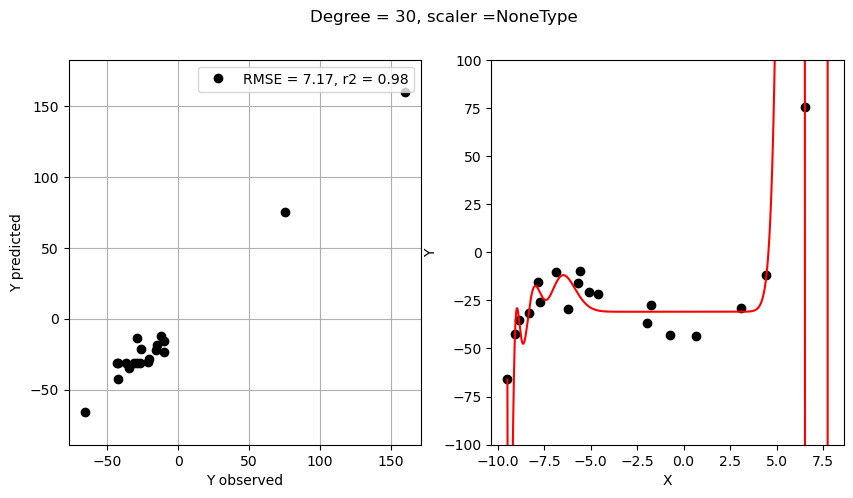

In [11]:
def evaluate_model (model, X, Y):
    model.fit(X, Y)
    Y_predicted = model.predict(X)
    rmse = np.sqrt(mean_squared_error(Y, Y_predicted))
    r2 = r2_score(Y, Y_predicted)
    
    print ('RMSE = ', rmse)
    X_smooth = np.linspace(X.min(), X.max(), 10000)
    Y_predicted_smooth = model.predict(X_smooth)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot (Y, Y_predicted, 'ok', label = 'RMSE = %.2f, r2 = %.2f'%(rmse, r2))
    plt.axis('equal')
    plt.grid()
    plt.xlabel('Y observed')
    plt.ylabel('Y predicted')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(X, Y, 'ok')
    plt.ylim([-100, 100])
    plt.plot(X_smooth, Y_predicted_smooth, '-r')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.suptitle('Degree = %d, scaler =%s'%(model.degree, model.scaler.__class__.__name__))

model = PolynomialRegression(30) 
#model = PolynomialRegression(30, scaler=StandardScaler) 

evaluate_model (model, X, Y)


## Оптимизация ~~гиперпараметров~~ гиперпараметра методом конечного перебора

Подойдем к проблеме оптимизации гиперпараметра (степени полинома) формально и попробуем найти оптимальное значение. 

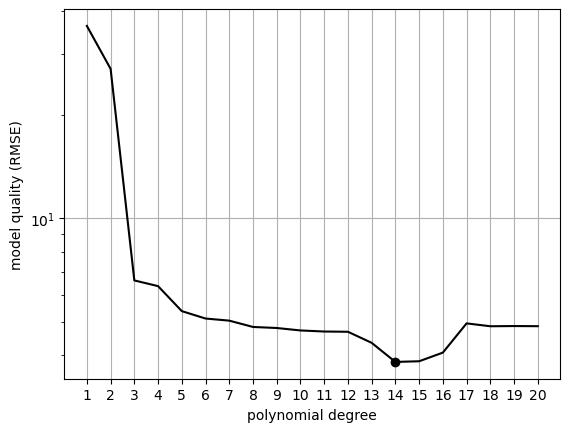

In [26]:
model_quality = []

degrees = range(1, 21)
for degree in degrees:
    model = PolynomialRegression(degree) #, scaler = StandardScaler)
    model.fit(X, Y)
    Y_predicted = model.predict(X)
    model_quality.append (np.sqrt(mean_squared_error(Y, Y_predicted)))

best_idx  = np.argmin(model_quality)

plt.plot (degrees, model_quality, '-k')
plt.plot (degrees[best_idx], model_quality[best_idx], 'ok')
plt.grid()
plt.xlabel('polynomial degree')
plt.ylabel('model quality (RMSE)')

plt.yscale('log')
_ = plt.xticks(degrees)

## Оптимизация ~~гиперпараметров~~ гиперпараметра методом конечного перебора - **теперь с разделением на тренировочную и тестовую выборки**

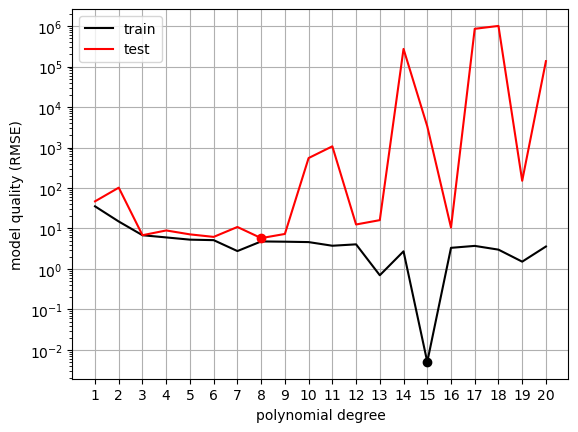

In [32]:

rmse_test = []
rmse_train = []

degrees = range(1, 21)

for degree in degrees:
    model = PolynomialRegression(degree)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)
    model.fit(x_train, y_train)
    y_test_predicted = model.predict(x_test)
    y_train_predicted = model.predict(x_train)
    
    rmse_test.append (np.sqrt(mean_squared_error(y_test, y_test_predicted)))
    rmse_train.append (np.sqrt(mean_squared_error(y_train, y_train_predicted)))

best_idx_test  = np.argmin(rmse_test)
best_idx_train = np.argmin(rmse_train)


plt.plot (degrees, rmse_train, '-k', label = 'train')
plt.plot (degrees, rmse_test, '-r', label = 'test')
plt.plot (degrees[best_idx_train], rmse_train[best_idx_train], 'ok')
plt.plot (degrees[best_idx_test], rmse_test[best_idx_test], 'or')

plt.grid()
plt.legend()
plt.xlabel('polynomial degree')
plt.ylabel('model quality (RMSE)')

plt.yscale('log')
_ = plt.xticks(degrees)